In [1]:
import torch

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [2]:
from torchvision import transforms, datasets, utils

BATCH_SIZE = 64

transform_FashionMNIST = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_dataset = datasets.FashionMNIST(root = '../data',
                                         train = True,
                                         download = True,
                                         transform = transform_FashionMNIST)

test_dataset = datasets.FashionMNIST(root = '../data',
                                train = False,
                                download = True,
                                transform = transform_FashionMNIST)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle=True)

In [3]:
import torch.nn as nn
from torchsummary import summary

class Custom_CNN(nn.Module):
    def __init__(self):
        super(Custom_CNN, self).__init__()

        self.maxpool2d = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Conv2d(1,10,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(10,20,kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(20,40,kernel_size=5,stride=1)
        self.conv4 = nn.Conv2d(40,60,kernel_size=5,stride=1)

        self.bn1 = nn.BatchNorm2d(10)
        self.bn2 = nn.BatchNorm2d(20)
        self.bn3 = nn.BatchNorm2d(40)
        self.bn4 = nn.BatchNorm2d(60)
        
        self.fc1 = nn.Linear(960,100)
        self.dropout = nn.Dropout2d(p=0.2)
        self.fc2 = nn.Linear(100,10)

        
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x))) # (10, 28, 28)
        x = self.relu(self.bn2(self.conv2(x))) # (20, 28, 28)
        x = self.relu(self.bn3(self.conv3(x))) # (40, 24, 24)
        x = self.maxpool2d(x)                  # (40, 12, 12)
        x = self.relu(self.bn4(self.conv4(x))) # (60, 8, 8)
        x = self.maxpool2d(x)                  # (60, 4, 4)
        x = x.view(-1,960)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

model = Custom_CNN().to(DEVICE)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
       BatchNorm2d-2           [-1, 10, 28, 28]              20
              ReLU-3           [-1, 10, 28, 28]               0
            Conv2d-4           [-1, 20, 28, 28]           1,820
       BatchNorm2d-5           [-1, 20, 28, 28]              40
              ReLU-6           [-1, 20, 28, 28]               0
            Conv2d-7           [-1, 40, 24, 24]          20,040
       BatchNorm2d-8           [-1, 40, 24, 24]              80
              ReLU-9           [-1, 40, 24, 24]               0
        MaxPool2d-10           [-1, 40, 12, 12]               0
           Conv2d-11             [-1, 60, 8, 8]          60,060
      BatchNorm2d-12             [-1, 60, 8, 8]             120
             ReLU-13             [-1, 60, 8, 8]               0
        MaxPool2d-14             [-1, 6

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [4]:
import torch.optim as optim

LR = 0.01

optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.5)

In [5]:
import torch.nn.functional as F

def train_one_epoch(model, train_loader, optimizer, epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            test_loss += F.cross_entropy(output, target, reduction='sum').item()

            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    return test_loss, test_accuracy

In [6]:
EPOCHS = 3

for epoch in range(1, EPOCHS + 1):
    train_one_epoch(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.322661
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.672013
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.429752
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.310980
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.289740
[1] Test Loss: 0.3227, Accuracy: 88.66%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.269915
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.465681
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.170411
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.136430
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.254304
[2] Test Loss: 0.2887, Accuracy: 89.40%
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.144552
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.242062
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.320629
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.202797
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.258864
[3] Test Loss: 0.2533, Accuracy: 90.70%


In [7]:
CLASSES = dict()
for i in range(10) :
    CLASSES[i] = train_dataset.classes[i]

print(CLASSES)

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


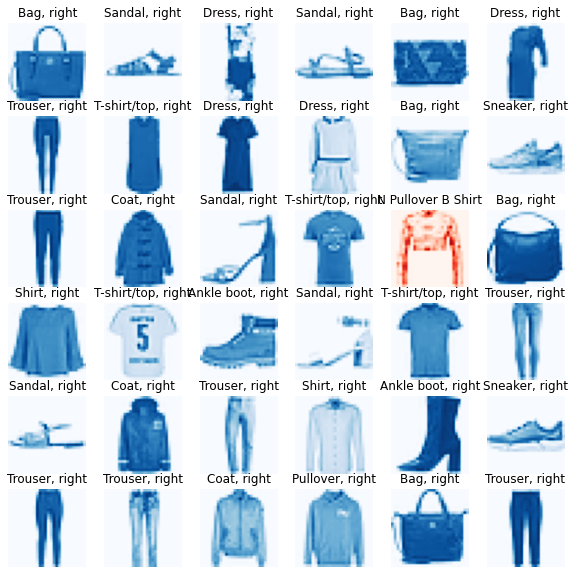

In [8]:
import matplotlib.pyplot as plt
import numpy as np

columns = 6
rows = 6
fig = plt.figure(figsize=(10,10))
 
model.eval()

for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_dataset))
    input_img = test_dataset[data_idx][0].unsqueeze(dim=0).to(DEVICE) 
 
    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = CLASSES[argmax.item()]
    label = CLASSES[test_dataset[data_idx][1]]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + ', right')
        cmap = 'Blues'
    else:
        plt.title('N ' + pred + ' B ' +  label)
        cmap = 'Reds'
    plot_img = test_dataset[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')
    
plt.show() 